<a href="https://colab.research.google.com/github/Khadijah-Trawally/viability_of_raman_coupling_QIAP_project/blob/main/viability_of_raman_coupling_QIAP_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install qutip

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import basis

In [60]:
class MESystem:
    """
    A class to represent a quantum mechanical system with Master Equation.

    Attributes:
    ----------
    N : int
        The number of states in the system.
    Hfunc : function
        The Hamiltonian function of the system.
    dets : list
        The detunings for the transitions.
    rabi_freqs : list
        The Rabi frequencies for the transitions.
    c_ops : list
        List of collapse operators.
    e_ops : list
        List of expectation operators.
    """

    def __init__(self, N, Hfunc, dets, rabi_freqs, c_ops, e_ops):
        """
        Constructs all the necessary attributes for the MESystem object.

        Parameters:
        ----------
        N : int
            The number of states in the system.
        Hfunc : function
            The Hamiltonian function of the system.
        dets : list
            The detunings for the transitions.
        rabi_freqs : list
            The Rabi frequencies for the transitions.
        c_ops : list
            List of collapse operators.
        e_ops : list
            List of expectation operators.
        """
        self.N = N
        self.Hfunc = Hfunc
        self.dets = dets
        self.rabi_freqs = rabi_freqs
        self.c_ops = c_ops
        self.e_ops = e_ops

    def evolve_system(self, times, rho0=None):
        """
        Evolves the system over the given time array.

        Parameters:
        ----------
        times : np.ndarray
            Array of time points at which to evaluate the system.
        rho0 : qutip.Qobj, optional
            Initial density matrix of the system (default is None).

        Returns:
        -------
        qt.Result
            Result object from the mesolve function.
        """
        if rho0 is None:
            rho0 = qt.basis(self.N, 0) * qt.basis(self.N, 0).dag()  # Initial population in |0>

        H = qt.Qobj(self.Hfunc(self.N, self.rabi_freqs, self.dets))
        result = qt.mesolve(H, rho0, times, self.c_ops, self.e_ops)

        return result



class MESystemPlotter:
    """
    Class for plotting the population dynamics of quantum states in a system.

    Parameters:
    ----------
    N : int
        Number of states in the system.
    ham : qutip.Qobj
        Hamiltonian of the system.
    delta : float
        Detuning parameter delta.
    Delta : float
        Detuning parameter Delta.
    omega_0 : float
        Omega parameter 0.
    omega_1 : float
        Omega parameter 1.
    e_ops : list of qutip.Qobj
        List of operators for expectation values.
    """
    labels = ['|0⟩', '|1⟩', '|e⟩', '|d⟩']

    def __init__(self, N, ham, delta, Delta, omega_0, omega_1, e_ops):
        self.N = N
        self.ham = ham
        self.delta = delta
        self.Delta = Delta
        self.omega_0 = omega_0
        self.omega_1 = omega_1
        self.e_ops = e_ops

    def plot_population(self, times, result, filename):
        """
        Plots the population dynamics of the states and saves the plot to a file.

        Parameters:
        ----------
        times : np.ndarray
            Array of time points.
        result : qt.Result
            Result object from the mesolve function.
        filename : str
            The filename to save the plot.
        """
        plt.figure(figsize=(10, 6))
        for idx, e_op in enumerate(self.e_ops):
            plt.plot(times, result.expect[idx], label=f'{self.labels[idx]} Population')
        plt.xlabel('Time (s)')
        plt.ylabel('Population')
        plt.title('Population Dynamics of States')
        plt.legend()
        plt.grid(True)
        plt.savefig(filename)
        plt.show()


    def plot_population_gamma_values(self, times, gamma_0_values, gamma_1_values, filename, gamma_d=0.3):

        """
        Plots the population dynamics for different gamma values and saves the plot to a file.

        Parameters:
        ----------
        times : np.ndarray
            Array of time points.
        gamma_0_values : list of float
            List of gamma_0 values to plot.
        gamma_1_values : list of float
            List of gamma_1 values to plot.
        filename : str
            The filename to save the plot.
        gamma_d : float, optional
            gamma_d value for the decay |e⟩ -> |d⟩, by default 0.3.
        """
        fig, axs = plt.subplots(len(gamma_0_values), len(gamma_1_values), figsize=(15, 10), sharex=True, sharey=True)

        ket = sigma_ops(self.N)

        for i, gamma_0 in enumerate(gamma_0_values):
            for j, gamma_1 in enumerate(gamma_1_values):
                if self.N == 3:
                    c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
                             gamma_1**0.5 * ket[1] * ket[2].dag()]  # Decay |e⟩ -> |1⟩
                else:
                    c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
                             gamma_1**0.5 * ket[1] * ket[2].dag(),  # Decay |e⟩ -> |1⟩
                             gamma_d**0.5 * ket[3] * ket[2].dag()]  # Decay |e⟩ -> |d⟩

                sys = MESystem(self.N, self.ham, [self.delta, self.Delta], [self.omega_0, self.omega_1], c_ops, self.e_ops)

                # Simulate the system
                result = sys.evolve_system(times=times)
                for idx, e_op in enumerate(self.e_ops):
                    axs[i, j].plot(times, result.expect[idx], label=f'{self.labels[idx]} Population')

                axs[i, j].set_xlabel('Time')
                axs[i, j].set_ylabel('Population')
                axs[i, j].set_title(f'$\gamma_0$ = {gamma_0}, $\gamma_1$ = {gamma_1}')


                axs[i, j].legend()
                axs[i, j].grid(True)
        plt.title('Population Dynamics of States with different decay rates')
        plt.tight_layout()

        # Save the figure
        plt.savefig(filename)

        # Show the figure
        plt.show()

    def plot_population_detuning_values(self, times, delta_values, Delta_values, filename, gamma_0=0.1, gamma_1=0.1, gamma_d=0.3):

        """
        Plots the population dynamics for different detuning values and saves the plot to a file.

        Parameters:
        ----------
        times : np.ndarray
            Array of time points.
        delta_values : list of float
            List of detuning values for delta to plot.
        Delta_values : list of float
            List of detuning values for Delta to plot.
        filename : str
            The filename to save the plot.
        gamma_0 : float, optional
            Gamma_0 value for the decay |e⟩ -> |0⟩, by default 0.1.
        gamma_1 : float, optional
            Gamma_1 value for the decay |e⟩ -> |1⟩, by default 0.1.
        gamma_d : float, optional
            Gamma_d value for the decay |e⟩ -> |d⟩, by default 0.3.
        """
        fig, axs = plt.subplots(len(delta_values), len(Delta_values), figsize=(15, 10), sharex=True, sharey=True)

        ket = sigma_ops(self.N)

        for i, delta in enumerate(delta_values):
            for j, Delta in enumerate(Delta_values):
                if self.N == 3:
                    c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
                             gamma_1**0.5 * ket[1] * ket[2].dag()]  # Decay |e⟩ -> |1⟩
                else:
                    c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
                             gamma_1**0.5 * ket[1] * ket[2].dag(),  # Decay |e⟩ -> |1⟩
                             gamma_d**0.5 * ket[3] * ket[2].dag()]  # Decay |e⟩ -> |d⟩

                sys = MESystem(self.N, self.ham, [delta, Delta], [self.omega_0, self.omega_1], c_ops, self.e_ops)

                # Simulate the system
                result = sys.evolve_system(times=times)
                for idx, e_op in enumerate(self.e_ops):
                    axs[i, j].plot(times, result.expect[idx], label=f'{self.labels[idx]} Population')

                axs[i, j].set_xlabel('Time')
                axs[i, j].set_ylabel('Population')
                axs[i, j].set_title(f'$\delta$ = {delta}, $\Delta$ = {Delta}')

                axs[i, j].legend()
                axs[i, j].grid(True)

        plt.tight_layout()


        # Save the figure
        plt.savefig(filename)

        # Show the figure
        plt.show()






In [61]:
def sigma_ops(N):

  return [basis(N, i) for i in range(N)]

def ham(N, omega, delta):
      """
      Constructs the Hamiltonian for the far-detuned system.

      Parameters:
      ----------
      omega : list
          List of Rabi frequencies for the transitions.
      delta : list
          List of detunings for the transitions.

      Returns:
      -------
      qt.Qobj
          The Hamiltonian of the system as a Qobj.

      """



      ket = sigma_ops(N)


      omega0, omega1 = omega
      delta0, delta1 = delta
      #detu = np.abs(delta1 - delta0)

      H = delta0 * ket[1] * ket[1].dag() + delta1 * ket[2] * ket[2].dag() +\
          omega0 / 2 * (ket[0] * ket[2].dag() + ket[2] * ket[0].dag()) +\
          omega1 / 2 * (ket[1] * ket[2].dag() + ket[2] * ket[1].dag())

      return H



## Decay into one of the levels |0⟩ (or |1⟩) with rate γ0 (|γ1⟩).

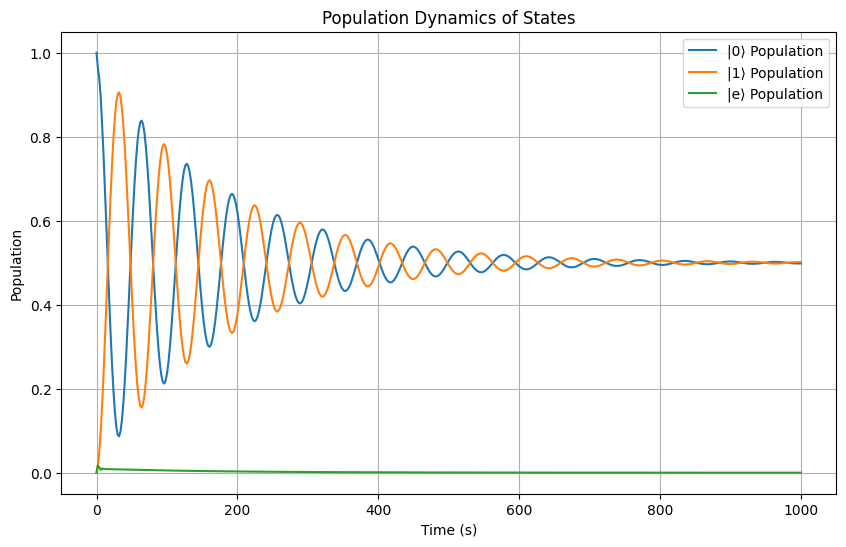

In [63]:
N = 3
delta = 0.0 # detuning for |e⟩ <-> |1⟩
Delta = 5


omega_0 = 1  # Rabi frequency for |e⟩ <-> |0⟩
omega_1 = 1  # Rabi frequency for |e⟩ <-> |1⟩


gamma_0 = 0.3  # Decay rate for |e⟩ -> |0⟩
gamma_1 = 0.3 # Decay rate for |e⟩ -> |1⟩
# H_int =  hamiltonian(N)


ket = sigma_ops(N)
c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
          gamma_1**0.5 * ket[1]* ket[2].dag()]  # Decay |e⟩ -> |1⟩

e_ops = [ket[0]* ket[0].dag(), ket[1] * ket[1].dag(), ket[2] * ket[2].dag()]

sys = MESystem(N, ham, [delta, Delta], [ omega_0 ,  omega_1], c_ops, e_ops)

# Time array
t = np.linspace(0, 1000, 500)

# Simulate the system
result = sys.evolve_system(times=t)
plotter = MESystemPlotter(N, ham, delta, Delta, omega_0, omega_1, e_ops)

plotter.plot_population(t, result, 'population_dynamics.png')

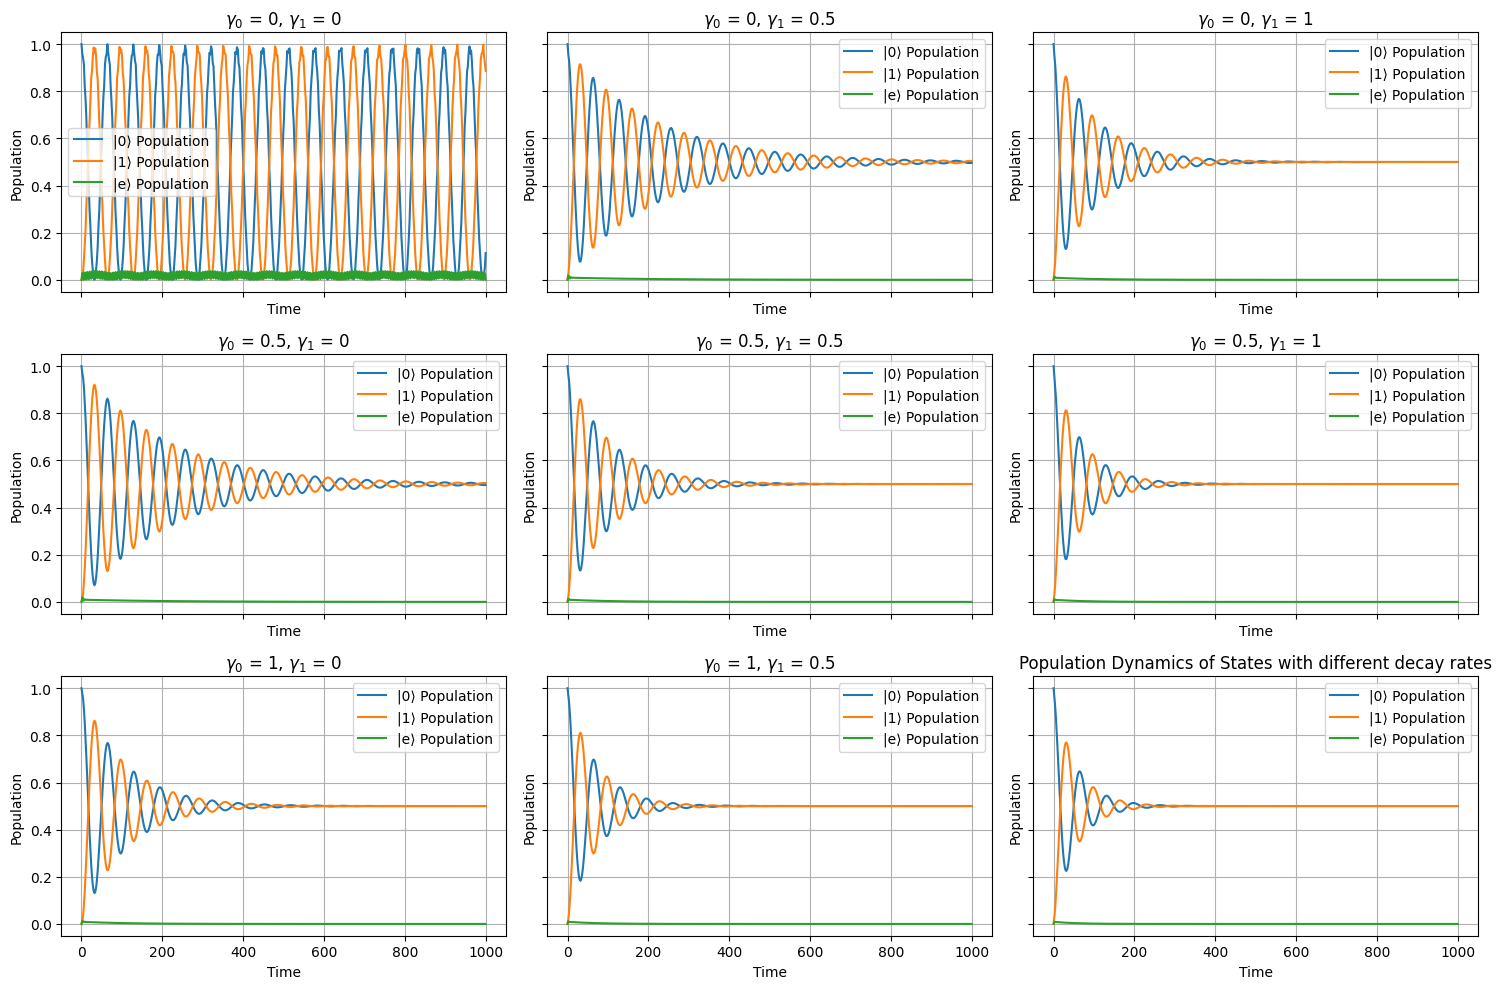

In [64]:


if __name__ == '__main__':



      # Time array
    t = np.linspace(0, 1000, 500)
    N = 3

    e_ops = [ket[0]* ket[0].dag(), ket[1] * ket[1].dag(), ket[2] * ket[2].dag()]




    gamma_0_values = [0,  0.5, 1]
    gamma_1_values = [0, 0.5, 1]

    plotter.plot_population_gamma_values(t, gamma_0_values, gamma_1_values,  'population_dynamics1.png')


### Decay into a dark state |d⟩ (orthogonal to the other 3) with rate γd

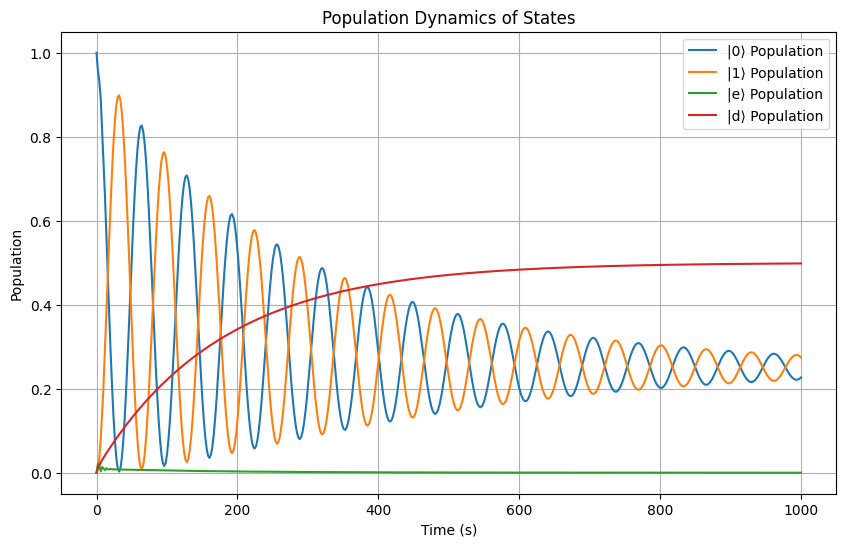

In [65]:
if __name__ == '__main__':

    N = 4


    ket = sigma_ops(N)
    delta = 0.0 # Far detuning for |e⟩ <-> |1⟩ transition
    Delta= 5


    omega_0 = 1  # Rabi frequency for |e⟩ <-> |0⟩
    omega_1 = 1 # Rabi frequency for |e⟩ <-> |1⟩



    gamma_0 = 0.3 # Decay rate for |e⟩ -> |0⟩
    gamma_1 = 0.3  # Decay rate for |e⟩ -> |1⟩
    gamma_d = 0.3  # Decay rate for |e⟩ -> |d⟩



    c_ops = [gamma_d**0.5 * ket[3]* ket[2].dag()]  # Decay |e⟩ -> |d⟩

    e_ops = [ket[0]* ket[0].dag(), ket[1] * ket[1].dag(), ket[2] * ket[2].dag(), ket[3] * ket[3].dag()]
    sys = MESystem(N, ham, [delta, Delta], [omega_0 ,  omega_1], c_ops, e_ops)


    t = np.linspace(0, 1000, 500)

    # Simulate the system
    result = sys.evolve_system(times=t)

    plotter = MESystemPlotter(N, ham, delta, Delta, omega_0, omega_1, e_ops)

    plotter.plot_population(t, result, 'population_dynamics_dark.png')


### Decay into all of the above combined, with 3 separate rates γ0, γ1 and γd.

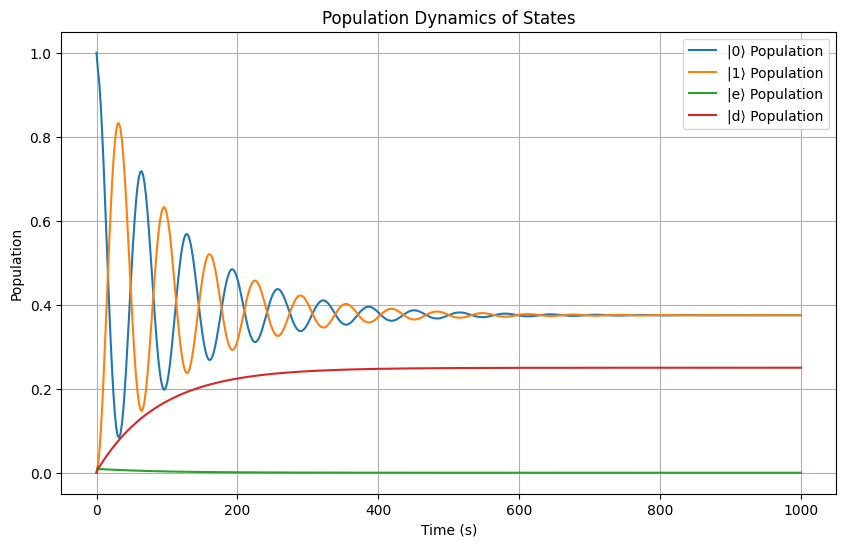

In [66]:
if __name__ == '__main__':



    c_ops = [gamma_0**0.5 * ket[0] * ket[2].dag(),  # Decay |e⟩ -> |0⟩
             gamma_1**0.5 * ket[1] * ket[2].dag(),  # Decay |e⟩ -> |1⟩
             gamma_d**0.5 * ket[3] * ket[2].dag()]  # Decay |e⟩ -> |d⟩




    sys = MESystem(N, ham, [delta, Delta], [omega_0 ,  omega_1], c_ops, e_ops)


    t = np.linspace(0, 1000, 500)

    # Simulate the system
    result = sys.evolve_system(times=t)

    plotter = MESystemPlotter(N, ham, delta, Delta, omega_0, omega_1, e_ops)

    plotter.plot_population(t, result, 'population_dynamics_all.png')



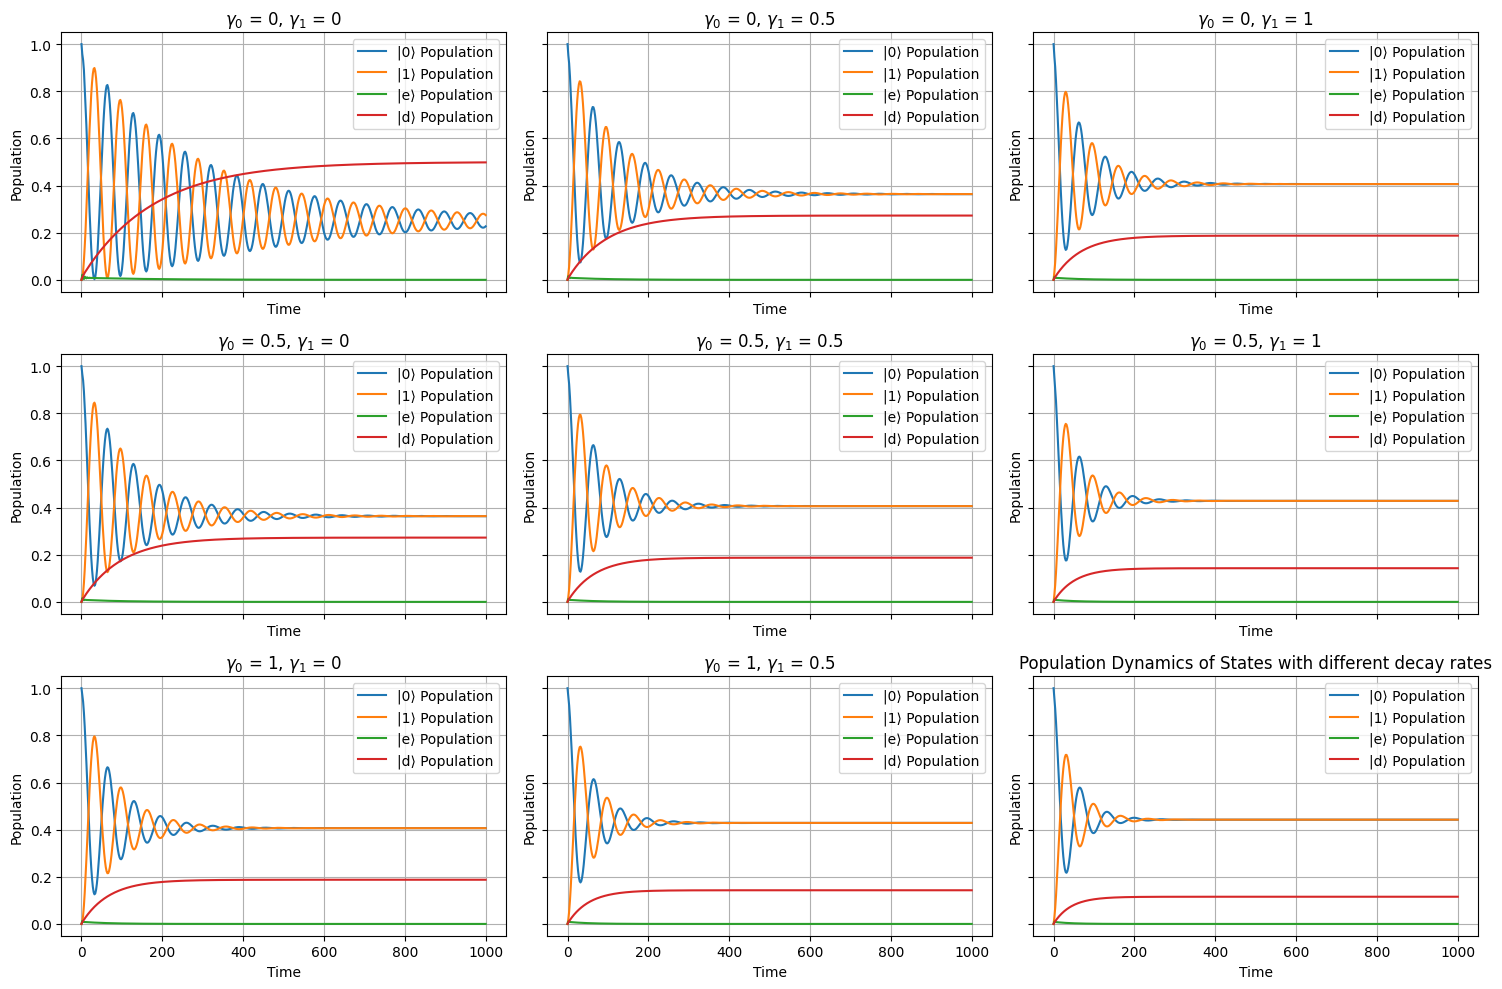

In [67]:


if __name__ == '__main__':



    t = np.linspace(0, 1000, 500)
    N = 4

    e_ops = [ket[0]* ket[0].dag(), ket[1] * ket[1].dag(), ket[2] * ket[2].dag(), ket[3] * ket[3].dag()]



    plotter = MESystemPlotter(N, ham, delta, Delta, omega_0, omega_1, e_ops)



    gamma_0_values = [0,  0.5, 1]
    gamma_1_values = [0, 0.5, 1]

    plotter.plot_population_gamma_values(t, gamma_0_values, gamma_1_values,  'population_dynamics2.png')

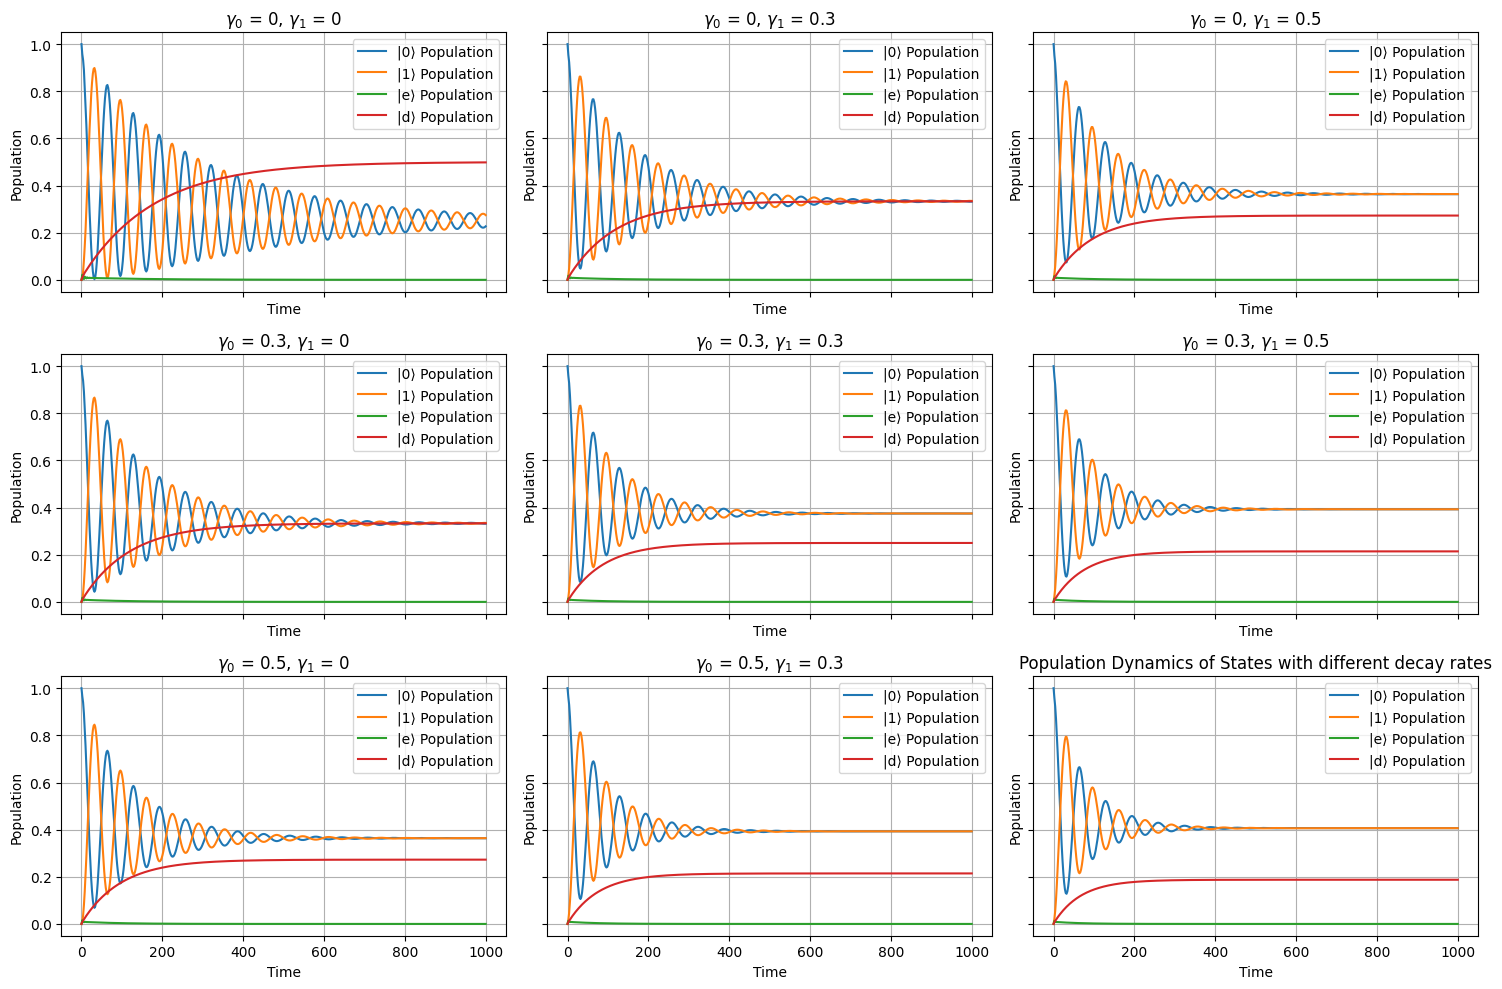

In [68]:
if __name__ == '__main__':




    e_ops = [ket[0]* ket[0].dag(), ket[1] * ket[1].dag(), ket[2] * ket[2].dag(), ket[3] * ket[3].dag()]

    # Define different values for Gamma_eg1 and Gamma_eg2
    gamma_eg1_values = [0, .3, .5]
    gamma_eg2_values = [0, .3, .5]

    plotter.plot_population_gamma_values(t, gamma_eg1_values, gamma_eg2_values,  'f2')


# APPENDIX

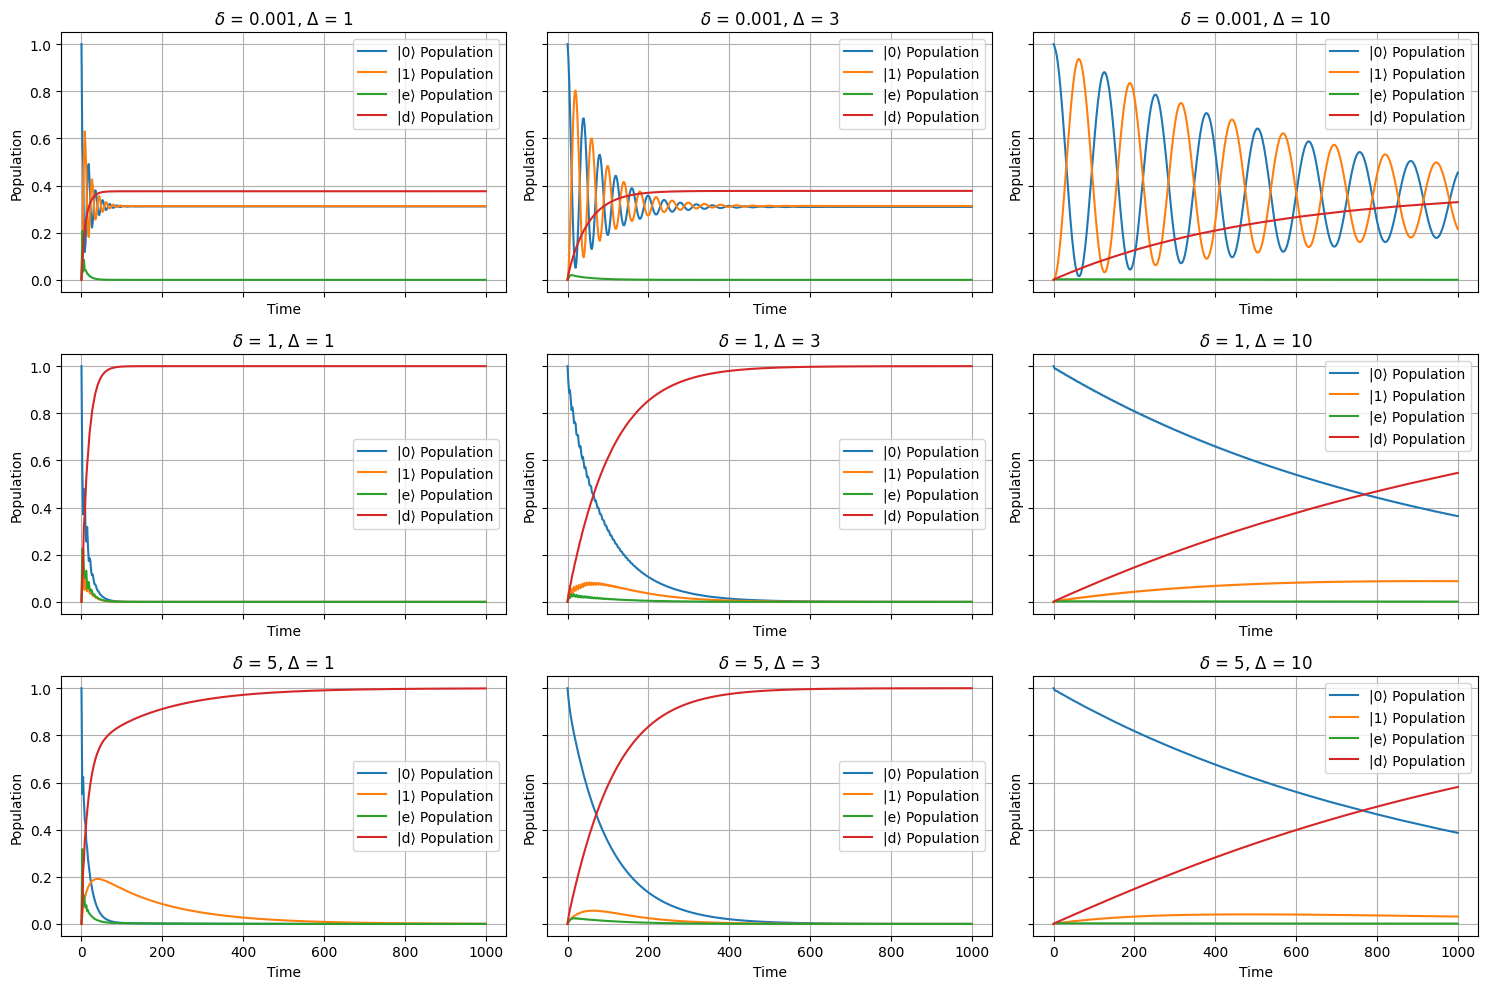

In [69]:

delta_values = [0.001, 1, 5]
Delta_values = [1, 3, 10]


plotter.plot_population_detuning_values(t, delta_values, Delta_values, 'population_dynamics_detuning.png')